In [13]:
import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
from typing import List
#from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict

In [14]:
def read_experiments(experimnt_history):
    with open(experimnt_history, 'r') as f:
        obj = yaml.safe_load(f)
    
    experiments = cattrs.structure(obj, List[Experiment])
    return experiments


In [15]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_c4_more_checkpoints_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]

experiment.trials[0].all_results

[{'Books': ValResult(domain='Books', loss=6.422241628170013, perplexity=6.422241628170013, eval_tokens=262144, train_tokens_seen=99999744, loss_tokens_lower_95=-1.0, loss_tokens_upper_95=-1.0),
  'C4': ValResult(domain='C4', loss=5.38793221116066, perplexity=5.38793221116066, eval_tokens=262144, train_tokens_seen=99999744, loss_tokens_lower_95=-1.0, loss_tokens_upper_95=-1.0)},
 {'Books': ValResult(domain='Books', loss=6.219429433345795, perplexity=6.219429433345795, eval_tokens=262144, train_tokens_seen=199999488, loss_tokens_lower_95=-1.0, loss_tokens_upper_95=-1.0),
  'C4': ValResult(domain='C4', loss=5.081719726324081, perplexity=5.081719726324081, eval_tokens=262144, train_tokens_seen=199999488, loss_tokens_lower_95=-1.0, loss_tokens_upper_95=-1.0)},
 {'Books': ValResult(domain='Books', loss=6.050170391798019, perplexity=6.050170391798019, eval_tokens=262144, train_tokens_seen=299999232, loss_tokens_lower_95=-1.0, loss_tokens_upper_95=-1.0),
  'C4': ValResult(domain='C4', loss=4.9

In [16]:
def parse_results(experiment: Experiment, eval_idx):
    weights1 = []
    res1 = []
    res2 = []
    res = []

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2
    key1 = list(trial0.val_results.keys())[0]
    key2 = list(trial0.val_results.keys())[1]

    for trial in experiment.trials:
        w1 = trial.true_mixing_weights[key1]
        w2 = trial.true_mixing_weights[key2]
        weights1.append(w1)

        res1.append(trial.all_results[eval_idx][key1].perplexity)  
        res2.append(trial.all_results[eval_idx][key2].perplexity)

        weighted_perplexity = (res1[-1] + res2[-1]) / 2
        res.append(weighted_perplexity)
    
    res = [x for _, x in sorted(zip(weights1, res), key=lambda pair: pair[0])]
    res1 = [x for _, x in sorted(zip(weights1, res1), key=lambda pair: pair[0])]
    res2 = [x for _, x in sorted(zip(weights1, res2), key=lambda pair: pair[0])]
    weights1 = sorted(weights1)

    tokens_seen = experiment.trials[0].all_results[eval_idx][key1].train_tokens_seen
    
    return {
        "weights1": weights1,
        "res1": res1,
        "res2": res2,
        "res": res,
        "tokens_seen": tokens_seen
    }
        


In [17]:
results = []
for i in range(5):
    results.append(parse_results(experiment, i))

In [18]:
def visualize(results, experiment: Experiment):
    # create 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2
    key1 = list(trial0.val_results.keys())[0]
    key2 = list(trial0.val_results.keys())[1]

    labels = [f"{result['tokens_seen'] // 1_000_000}M" for result in results]
    lines = []
    # Todo add one legend for all plots

    for result in results:
        # plot 1
        line, = axs[0].plot(result["weights1"], result["res"], '-o')
        lines.append(line)
        axs[0].set_xlabel(f'Mixing Weight {key1}')
        axs[0].set_ylabel('Weighted Perplexity')
        #axs[0].set_yscale('log')
        # plot 2
        axs[1].plot(result["weights1"], result["res1"],'-o')
        axs[1].set_xlabel(f'Mixing Weight {key1}')
        axs[1].set_ylabel(f'{key1} Perplexity')
        axs[1].set_yscale('log')

        # plot 3
        axs[2].plot([1 - x for x in result["weights1"]], result["res2"], '-o')
        axs[2].set_xlabel(f'Mixing Weight {key2}')
        axs[2].set_ylabel(f'{key2} Perplexity')
        axs[2].set_yscale('log')

    # add legend centered over all plots
    fig.legend(lines, labels, loc='upper center', ncol=len(labels))
    

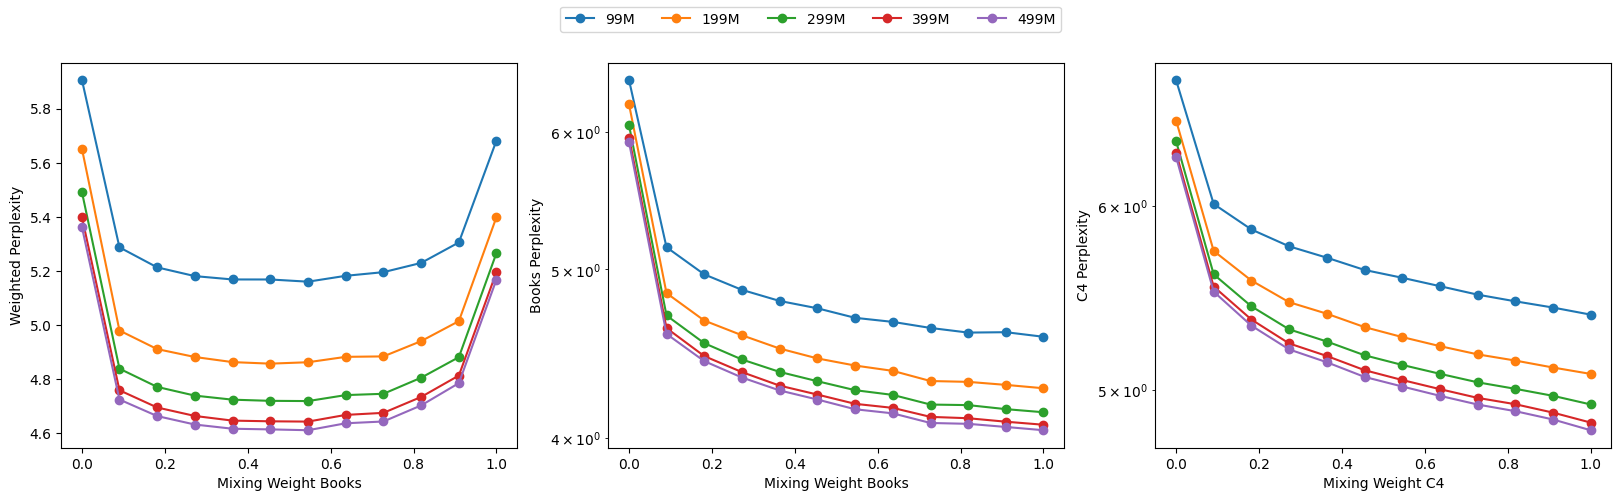

In [19]:
visualize(results, experiment)

In [20]:
def plot_visualizations(experiment, start_teratrions=None):
    all_weights1 = []
    res1 = []
    res2 = []
    res = []

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2
    key1 = list(trial0.val_results.keys())[0]
    key2 = list(trial0.val_results.keys())[1]

    for trial in experiment.trials:



        if trial.val_results is None:
            print(f"Skipping trial {trial.idx} as it has no val results")
            continue
        

        w1 = trial.true_mixing_weights[key1]
        w2 = trial.true_mixing_weights[key2]

        
        res1.append(trial.val_results[key1].perplexity)
        res2.append(trial.val_results[key2].perplexity)
        

        weights1.append(w1)
        res.append(trial.weighted_val_perplexity)

    # create 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

    # reorder results according to weights1
    res = [x for _, x in sorted(zip(weights1, res), key=lambda pair: pair[0])]
    res1 = [x for _, x in sorted(zip(weights1, res1), key=lambda pair: pair[0])]
    res2 = [x for _, x in sorted(zip(weights1, res2), key=lambda pair: pair[0])]
    weights1 = sorted(weights1)

    # plot 2
    axs[1].plot(weights1, res1,'-o')
    axs[1].set_xlabel(f'Mixing Weight {key1}')
    axs[1].set_ylabel(f'{key1} Perplexity')
    axs[1].set_yscale('log')

    # plot 3
    axs[1].plot(weights1, res2, '-o')
    axs[1].set_xlabel(f'Mixing Weight {key1}')
    axs[1].set_ylabel(f'{key2} Perplexity')
    axs[1].set_yscale('log')


In [21]:
def plot_visualizations2(experiment, start_teratrions=None):
    weights1 = []
    res1 = []
    res2 = []
    res = []

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2
    key1 = list(trial0.val_results.keys())[0]
    key2 = list(trial0.val_results.keys())[1]

    for trial in experiment.trials:
        if trial.val_results is None:
            print(f"Skipping trial {trial.idx} as it has no val results")
            continue
        

        w1 = trial.true_mixing_weights[key1]
        w2 = trial.true_mixing_weights[key2]

        
        res1.append(trial.val_results[key1].perplexity)
        res2.append(trial.val_results[key2].perplexity)
        

        weights1.append(w1)
        res.append(trial.weighted_val_perplexity)

    # create 3 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

    # reorder results according to weights1
    res = [x for _, x in sorted(zip(weights1, res), key=lambda pair: pair[0])]
    res1 = [x for _, x in sorted(zip(weights1, res1), key=lambda pair: pair[0])]
    res2 = [x for _, x in sorted(zip(weights1, res2), key=lambda pair: pair[0])]
    weights1 = sorted(weights1)

    # plot 2
    axs[0].plot(weights1, res1,'-o')
    axs[0].set_xlabel(f'Mixing Weight {key1}')
    axs[0].set_ylabel(f'{key1} Perplexity')
    axs[0].set_yscale('log')

    # plot 3
    axs[1].plot(weights1, res2, '-o')
    axs[1].set_xlabel(f'Mixing Weight {key1}')
    axs[1].set_ylabel(f'{key2} Perplexity')
    axs[1].set_yscale('log')


In [22]:
plot_visualizations(experiment)

UnboundLocalError: local variable 'weights1' referenced before assignment

We can kinda reproduce their trend, however, at the extrems we completely break the assumption

This probably makes sense, however as it is never adapted I am curious how to handle this

# Replicating results with 80M

Books, C4

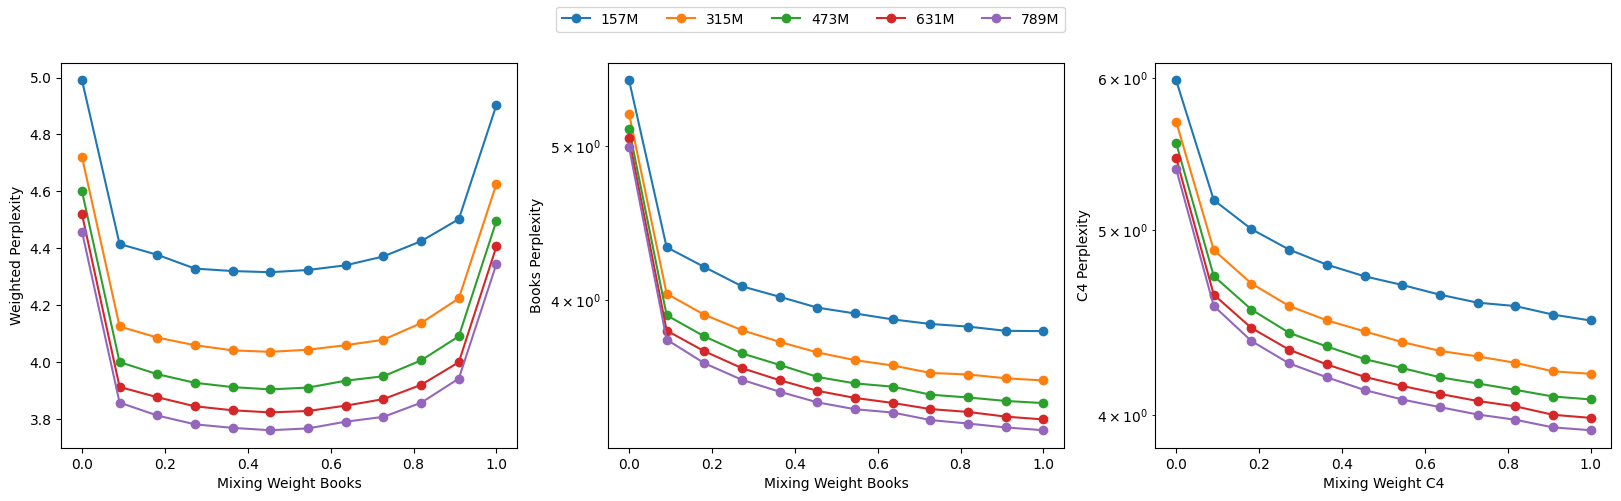

In [ ]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_c4_80M_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]

results = []
for i in range(5):
    results.append(parse_results(experiment, i))

visualize(results, experiment)
